# Channel Flow (Steady) DEMO code

This notebook demonstrates solving steady-state channel flow (uniform inlet) using Physics-Informed Neural Networks (PINNs).

In [20]:
import deepflow as df
print("Deepflow is runned on:", df.device) # to change to cpu use df.device = 'cpu'
df.manual_seed(69) # for reproducibility

Deepflow is runned on: cuda


## 1. Define Geometry Domain
Set up the computational domain: a rectangle with a circular obstacle (cylinder). This defines the area for simulation.

In [21]:
circle = df.geometry.circle(0.2, 0.2, 0.05)
rectangle = df.geometry.rectangle([0,1.1], [0,0.41])
area = rectangle - circle

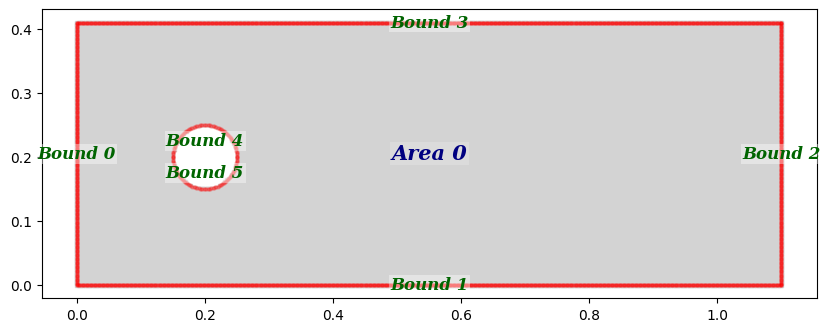

In [22]:
domain = df.domain(area, circle.bound_list)
domain.show_setup()

## 2. Define Physics
Define the Navier-Stokes equations for fluid flow and apply boundary conditions (e.g., no-slip walls, inlet velocity).

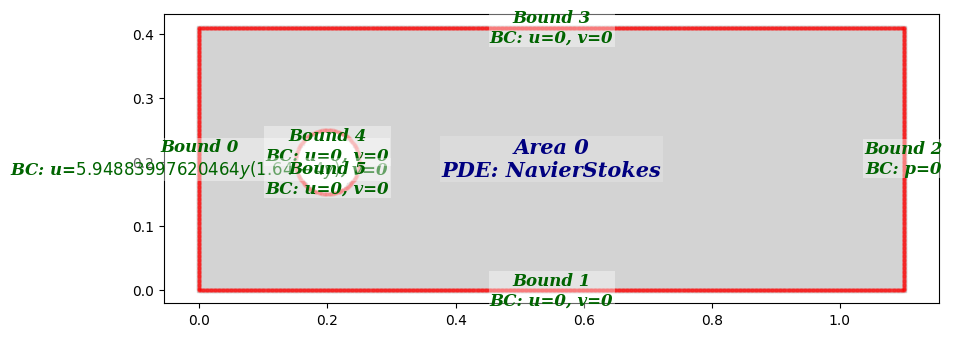

In [23]:
domain.bound_list[0].define_bc({'u': ['y', lambda x:  4*1*(0.41-x)*x/0.41**2], 'v': 0})
domain.bound_list[1].define_bc({'u': 0,'v': 0})
domain.bound_list[2].define_bc({'p': 0})
domain.bound_list[3].define_bc({'u': 0,'v': 0})
domain.bound_list[4].define_bc({'u': 0, 'v': 0})
domain.bound_list[5].define_bc({'u': 0, 'v': 0})
domain.area_list[0].define_pde(df.NavierStokes(U=0.00005, L=1, mu=0.001, rho=1000))
domain.show_setup()


Sample initial points for training.

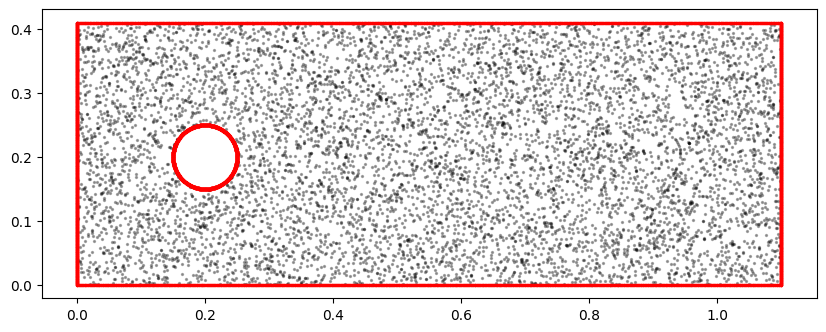

In [ ]:
domain.sampling_lhs(bound_sampling_res=[2000, 2000, 2000, 2000, 2000, 2000], area_sampling_res=[8000])
domain.show_coordinates(display_physics=False)




+

## 3. Train the PINN model

Define how collocation points are sampled during training.

In [25]:
# Define the loss calculation function
def calc_loss(model):
    # BC Loss
    bc_loss = 0.0
    for i, bc in enumerate(domain.bound_list):
        bc_loss += bc.calc_loss(model)

    # PDE Loss
    pde_loss = 0.0
    for i, area in enumerate(domain.area_list):
        pde_loss += area.calc_loss(model)

    # Total Loss
    total_loss = bc_loss + pde_loss # weight bc_loss more

    return {"bc_loss": bc_loss, "pde_loss": pde_loss, "total_loss": total_loss} # MUST RETURN IN THIS FORMAT

In [26]:
def do_in_adam(epoch, model):
    if epoch % 500 == 0 and epoch > 3000:
        domain.sampling_R3(bound_sampling_res=[2000, 2000, 2000, 2000, 2000, 2000], area_sampling_res=[8000])
        print(domain)
        
def do_in_lbfgs(epoch, model):
    if epoch % 100 == 0 and epoch > 0:
        domain.sampling_R3(bound_sampling_res=[2000, 2000, 2000, 2000, 2000, 2000], area_sampling_res=[8000])
        print(domain)

Train the model using Adam for initial training (faster convergence).

In [27]:
model0 = df.PINN(width=50, length=5, input_vars=['x','y'], output_vars=['u','v','p'])

# Train the model
model1, model1best = model0.train_adam(
    learning_rate=0.004,
    epochs=2000,
    calc_loss=calc_loss,
    threshold_loss=0.0005,
    do_between_epochs=do_in_adam)

Epoch: 1, total_loss: 0.73840, bc_loss: 0.73787, pde_loss: 0.00053
Epoch: 200, total_loss: 0.24235, bc_loss: 0.20552, pde_loss: 0.03684
Epoch: 400, total_loss: 0.20561, bc_loss: 0.17784, pde_loss: 0.02777
Epoch: 600, total_loss: 0.19116, bc_loss: 0.16512, pde_loss: 0.02604
Epoch: 800, total_loss: 0.18135, bc_loss: 0.15851, pde_loss: 0.02283
Epoch: 1000, total_loss: 0.17564, bc_loss: 0.15463, pde_loss: 0.02101
Epoch: 1200, total_loss: 0.16963, bc_loss: 0.15105, pde_loss: 0.01858
Epoch: 1400, total_loss: 0.15922, bc_loss: 0.13063, pde_loss: 0.02860
Epoch: 1600, total_loss: 0.13957, bc_loss: 0.11718, pde_loss: 0.02240
Epoch: 1800, total_loss: 0.14777, bc_loss: 0.09907, pde_loss: 0.04869
Epoch: 2000, total_loss: 0.11757, bc_loss: 0.09485, pde_loss: 0.02272


Refine the model using LBFGS for higher precision.

In [28]:
# Train the model
model2 = model1best.train_lbfgs(
    calc_loss=calc_loss,
    epochs=1000,
    threshold_loss=0.00001,
    do_between_epochs=do_in_lbfgs)

Epoch: 1974, total_loss: 0.10144, bc_loss: 0.08853, pde_loss: 0.01291
Epoch: 2024, total_loss: 0.00495, bc_loss: 0.00149, pde_loss: 0.00346
number of bound : ['0: 3150', '1: 2669', '2: 3172', '3: 2665', '4: 3043', '5: 3228']
number of area : ['0: 10510']
Epoch: 2074, total_loss: 0.00220, bc_loss: 0.00041, pde_loss: 0.00179
Epoch: 2124, total_loss: 0.00083, bc_loss: 0.00019, pde_loss: 0.00064
number of bound : ['0: 3859', '1: 3405', '2: 3838', '3: 3584', '4: 4127', '5: 4151']
number of area : ['0: 12707']
Epoch: 2174, total_loss: 0.00102, bc_loss: 0.00015, pde_loss: 0.00087
Epoch: 2224, total_loss: 0.00047, bc_loss: 0.00010, pde_loss: 0.00036
number of bound : ['0: 4749', '1: 4135', '2: 4627', '3: 4356', '4: 5020', '5: 5060']
number of area : ['0: 14813']
Epoch: 2274, total_loss: 0.00038, bc_loss: 0.00009, pde_loss: 0.00030
Epoch: 2324, total_loss: 0.00028, bc_loss: 0.00007, pde_loss: 0.00021
number of bound : ['0: 5487', '1: 4818', '2: 5634', '3: 4800', '4: 5604', '5: 5756']
number of 

Save or Load the model for later use

In [29]:
model2.save_as_pickle()
model2.load_from_pickle("model.pkl")

## 4. Visualization

### 4.1 Visualize area

In [80]:
# Create object for evaluation
area_eval = domain.area_list[0].evaluate(model2)
# Sampling uniform points
area_eval.sampling_area([60, 20])

In [70]:
area_eval["velocity_magnitude"] = (area_eval["u"]**2 + area_eval["v"]**2)**0.5

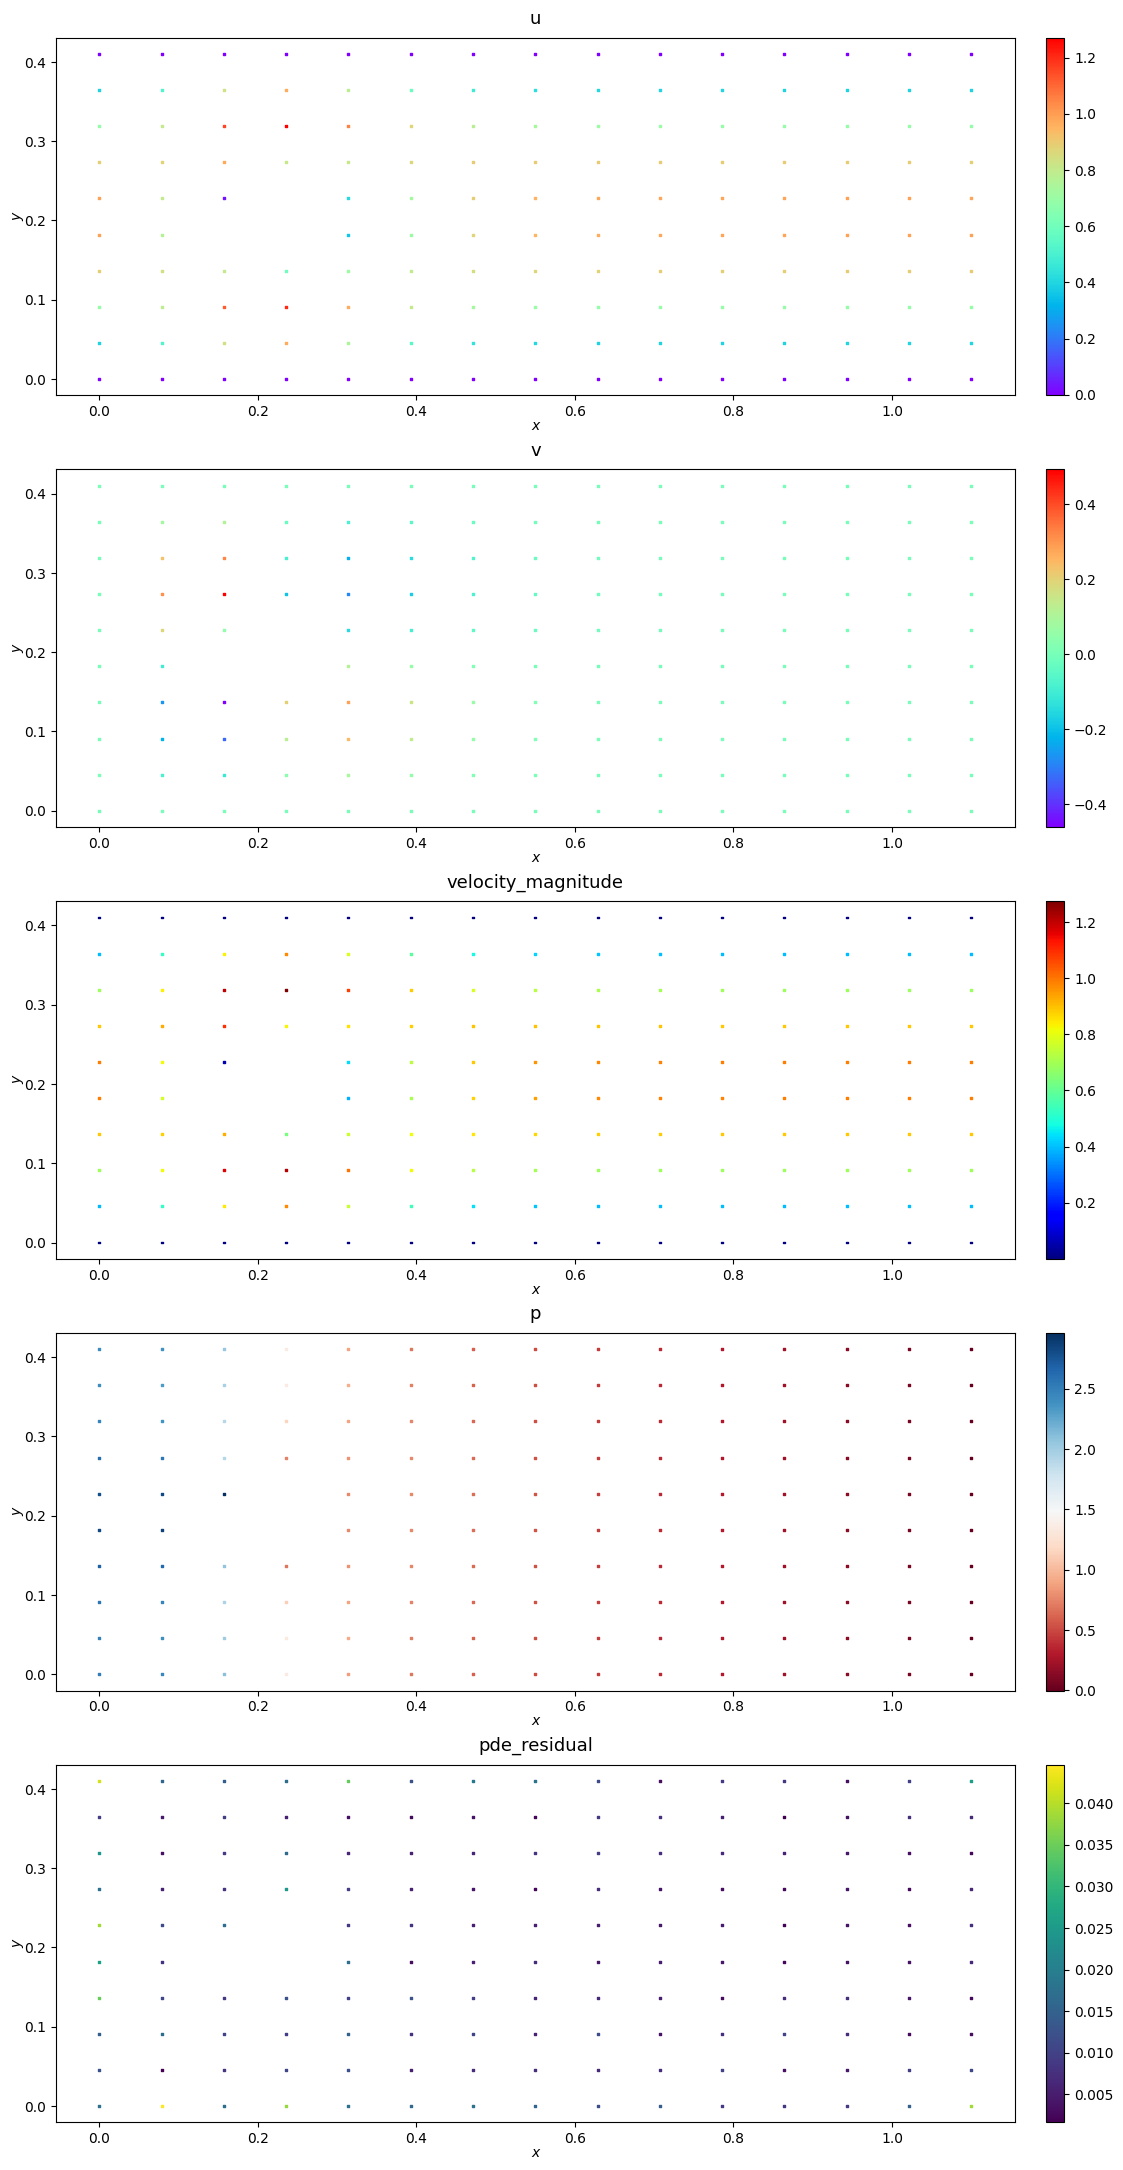

In [44]:
cmap_dict = {
    'u':'rainbow',
    'v':'rainbow',
    'velocity_magnitude': 'jet',
    'p':'RdBu',
    'pde_residual': 'viridis'}
colorplot_area_2d = area_eval.plot_color(cmap_dict, s=2).savefig("colorplot_2d")

[('pde_residual', 'viridis')]


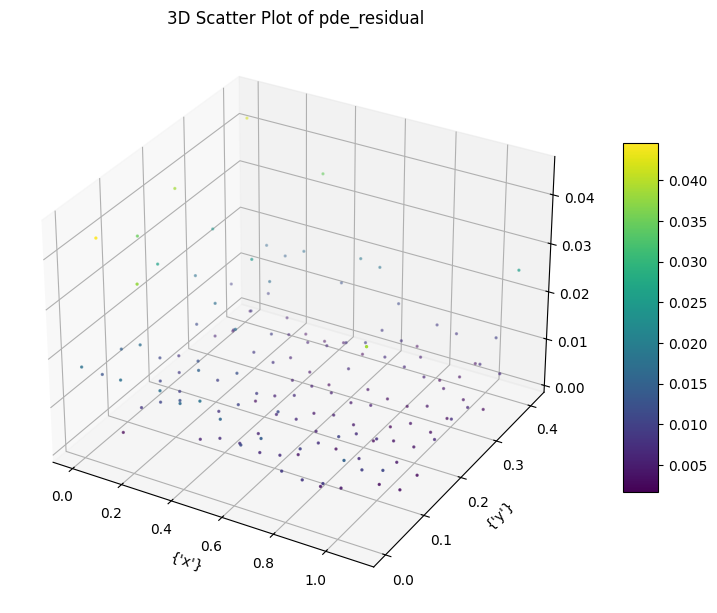

In [45]:
residual_plot_3d = area_eval.plot('pde_residual').savefig("residual_plot_3d.png")

In [46]:
print(area_eval.data_dict["x"])

[1.0000000e-06 1.0000000e-06 1.0000000e-06 1.0000000e-06 1.0000000e-06
 1.0000000e-06 1.0000000e-06 1.0000000e-06 1.0000000e-06 1.0000000e-06
 7.8571431e-02 7.8571431e-02 7.8571431e-02 7.8571431e-02 7.8571431e-02
 7.8571431e-02 7.8571431e-02 7.8571431e-02 7.8571431e-02 7.8571431e-02
 1.5714286e-01 1.5714286e-01 1.5714286e-01 1.5714286e-01 1.5714286e-01
 1.5714286e-01 1.5714286e-01 1.5714286e-01 1.5714286e-01 2.3571429e-01
 2.3571429e-01 2.3571429e-01 2.3571429e-01 2.3571429e-01 2.3571429e-01
 2.3571429e-01 2.3571429e-01 3.1428573e-01 3.1428573e-01 3.1428573e-01
 3.1428573e-01 3.1428573e-01 3.1428573e-01 3.1428573e-01 3.1428573e-01
 3.1428573e-01 3.1428573e-01 3.9285716e-01 3.9285716e-01 3.9285716e-01
 3.9285716e-01 3.9285716e-01 3.9285716e-01 3.9285716e-01 3.9285716e-01
 3.9285716e-01 3.9285716e-01 4.7142857e-01 4.7142857e-01 4.7142857e-01
 4.7142857e-01 4.7142857e-01 4.7142857e-01 4.7142857e-01 4.7142857e-01
 4.7142857e-01 4.7142857e-01 5.5000001e-01 5.5000001e-01 5.5000001e-01
 5.500

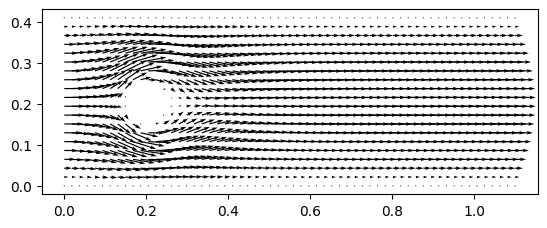

In [82]:
# Source - https://stackoverflow.com/a/35878030
# Posted by unutbu, modified by community. See post 'Timeline' for change history
# Retrieved 2026-01-30, License - CC BY-SA 3.0

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate

# lowercase variables are 1D arrays
x = area_eval.data_dict["x"]
y = area_eval.data_dict["y"]
u = area_eval.data_dict["u"]
v = area_eval.data_dict["v"]

plt.figure()
plt.quiver(x, y, u, v, scale_units='xy', angles='xy', scale= 20)
plt.gca().set_aspect('equal')
plt.show()


ValueError: 'x' must be strictly increasing

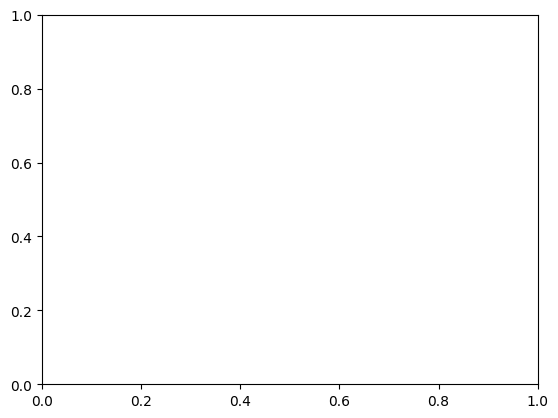

In [ ]:
import matplotlib.pyplot as plt
plt.streamplot(area_eval.data_dict["x"][:,], area_eval.data_dict["y"][:10],
               area_eval.data_dict["u"][:15], area_eval.data_dict["v"][:10],
               density=2, color='k', linewidth=0.5)

### 4.2 Visualize bound

In [33]:
# Create object for evaluation
bound_visual = domain.bound_list[2].evaluate(model2)
# Sampling uniform points
bound_visual.sampling_line(100)

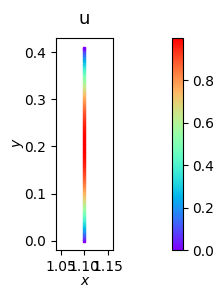

In [34]:
colorplot_bound = bound_visual.plot_color({'u':'rainbow'}).savefig("colorplot_bound.png")

[('u', 'blue')]


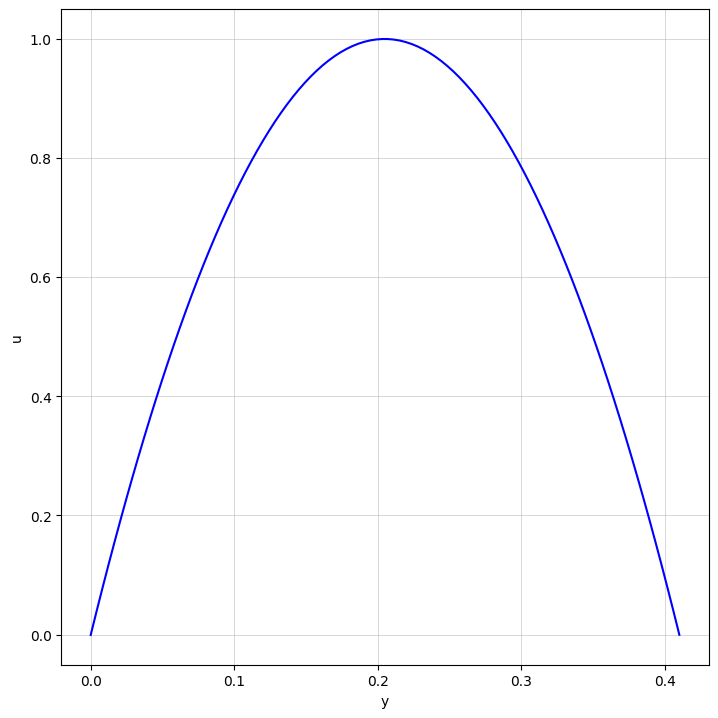

In [35]:
velocity_plot_outlet = bound_visual.plot(x_axis = 'y', y_axis={'u':'blue'})

## 4.3 Visualize Neural Network data

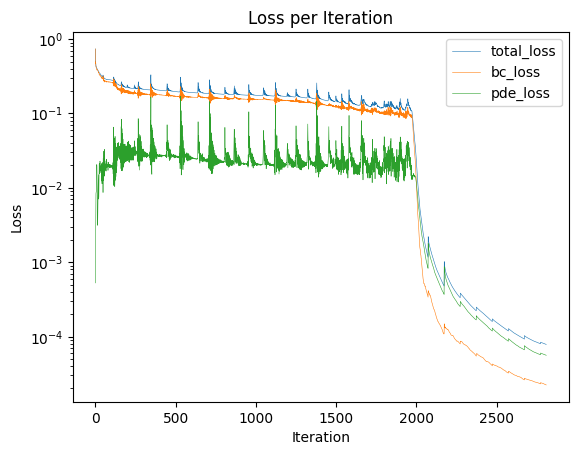

In [36]:
loss_history = bound_visual.plot_loss_curve(log_scale=True, linewidth=0.4).savefig("loss_history.png")

### 4.4 Export data

In [ ]:
# store the x,y,velocity_magnitude data
x_data = bound_visual.data_dict['x']
y_data = bound_visual.data_dict['y']
u_data = bound_visual.data_dict['u']

#save as txt file
import numpy as np
array = np.column_stack((x_data, y_data, u_data))
np.savetxt('outlet_velocity.txt', array)